In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import torchvision
import warnings
import copy
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [4]:
class CNN8(nn.Module):
    def __init__(self):
        super(CNN8,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(3,32,7,1,3,bias=False),               
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(32,64,7,1,3,bias=False),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        
        self.conv3=nn.Sequential(
            nn.Conv2d(64,128,5,1,3,bias=False),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        
        self.conv4=nn.Sequential(
            nn.Conv2d(128,256,5,1,1,bias=False),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv5=nn.Sequential(
            nn.Conv2d(256,256,3,1,1,bias=False),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv6=nn.Sequential(
            nn.Conv2d(256,128,3,1,1,bias=False),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.dense1=nn.Sequential(
            nn.Linear(1152,2048),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense2=nn.Sequential(
            nn.Linear(2048,1024),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense3=nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU()
        )
       
        self.out=nn.Linear(512,101)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)
        x=x.view(x.size(0),-1)
        x=self.dense1(x)
        x=self.dense2(x)
        x=self.dense3(x)
        output=self.out(x)
        return output       
cnn8=CNN8().cuda()
print(cnn8)

CNN8(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), 

In [5]:
EPOCH = 70
BATCH_SIZE=64
LR=0.001
optimizer=torch.optim.Adam(cnn8.parameters(),lr=LR,weight_decay=0.01)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
loss_func=nn.CrossEntropyLoss()

In [6]:
train_data = torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/Caltech101/train',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]))

eval_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/Caltech101/eval',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]))

test_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/Caltech101/test',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]))

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=False, num_workers=2)
test_loader=Data.DataLoader(dataset=test_data,batch_size=200,
                             shuffle=False, num_workers=2)

In [7]:
losses=[]
train_accs=[]
eval_accs=[]
best_model_wts = copy.deepcopy(cnn8.state_dict())         #change
best_acc = 0.0

for epoch in range(EPOCH):
    print('Step:')
    cnn8.train()   #change
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output=cnn8(b_x)   #change
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        
        if step%30==0:
            print(step)
            
    scheduler.step()        
    
    losses.append(loss.data)
    with torch.no_grad():
        cnn8.eval()   #change
        
        train_acc=[]
        for x,y in train_loader:
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()        
            output=cnn8(b_x)   #change
            pred_y=torch.max(output,1)[1].cuda().data.squeeze()
            accuracy=sum(pred_y==b_y).double()/b_y.size(0) 
            train_acc.append(accuracy)
            torch.cuda.empty_cache()
        train_acc=sum(train_acc)/len(train_acc)
        train_accs.append(train_acc)
        
        eval_acc=[]
        for x,y in eval_loader:
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()        
            output=cnn8(b_x)         #change
            pred_y=torch.max(output,1)[1].cuda().data.squeeze()
            accuracy=sum(pred_y==b_y).double()/b_y.size(0)
            eval_acc.append(accuracy)
            torch.cuda.empty_cache()
        eval_acc=sum(eval_acc)/len(eval_acc)
        eval_accs.append(eval_acc)
        
        
        if eval_acc>best_acc:
            best_acc = eval_acc
            best_model_wts = copy.deepcopy(cnn8.state_dict())         #change
            
    
    
    print('Epoch: %4s'%epoch,'| loss: ',loss.data,
            '| Train_acc: %6s'% train_acc.data,'| Eval_acc: %6s'%eval_acc.data) 
print('Best Eval acc: %6s'%best_acc)

Step:
0
30
60
90
Epoch:    0 | loss:  tensor(4.0603, device='cuda:0') | Train_acc: tensor(0.1762, device='cuda:0', dtype=torch.float64) | Eval_acc: tensor(0.1620, device='cuda:0', dtype=torch.float64)
Step:
0
30
60
90
Epoch:    1 | loss:  tensor(3.4082, device='cuda:0') | Train_acc: tensor(0.2114, device='cuda:0', dtype=torch.float64) | Eval_acc: tensor(0.2010, device='cuda:0', dtype=torch.float64)
Step:
0
30
60
90
Epoch:    2 | loss:  tensor(3.6554, device='cuda:0') | Train_acc: tensor(0.2816, device='cuda:0', dtype=torch.float64) | Eval_acc: tensor(0.2600, device='cuda:0', dtype=torch.float64)
Step:
0
30
60
90
Epoch:    3 | loss:  tensor(3.2514, device='cuda:0') | Train_acc: tensor(0.2973, device='cuda:0', dtype=torch.float64) | Eval_acc: tensor(0.2570, device='cuda:0', dtype=torch.float64)
Step:
0
30
60
90
Epoch:    4 | loss:  tensor(3.0654, device='cuda:0') | Train_acc: tensor(0.3029, device='cuda:0', dtype=torch.float64) | Eval_acc: tensor(0.2690, device='cuda:0', dtype=torch.floa

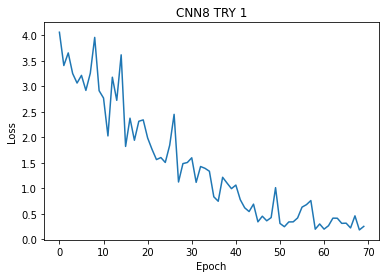

In [8]:
x=np.arange(len(losses))
plt.plot(x,losses)
plt.title('CNN8 TRY 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

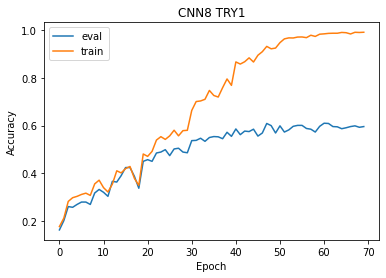

In [9]:
plt.plot(x,eval_accs,label='eval')
plt.plot(x,train_accs,label='train')
plt.title('CNN8 TRY1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()